#### Интеллектуальные технологии информационной безопасности. Практическая работа №7
|   Группа          |   ФИО             |   
|   :------------:  |   :------------:  |
|   М092501(71)     |   Шарибжанов И.Т. |

**Цель работы:**
Изучить и реализовать на практике метод покоординатного спуска для оптимизации весов нейронной сети. В ходе работы необходимо заменить стандартный оптимизатор Keras на собственную реализацию одного из градиентных методов для обучения модели бинарной классификации текстовых данных.

#### 1. Подготовка среды

На этом этапе мы настраиваем окружение (используем TensorFlow/Keras и NumPy), загружаем и предобрабатываем набор данных IMDB, а также создаем архитектуру нейронной сети в соответствии с описанием из книги Франсуа Шолле

Набор данных IMDB содержит 50 000 отзывов (25 000 для обучения, 25 000 для теста), каждый отзыв представлен как последовательность индексов слов (топ-10 000 самых частых слов). Мы векторизуем данные в бинарные векторы (one-hot encoding), где каждый отзыв становится вектором длиной 10 000 с 1 в позициях встречающихся слов.

Модель: полносвязная сеть с двумя скрытыми слоями по 16 нейронов (ReLU активация) и выходным слоем с 1 нейроном (sigmoid для бинарной классификации).

In [ ]:
%pip install tensorflow matplotlib numpy pandas

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb

# # Установка seed для воспроизводимости
# np.random.seed(42)
# tf.random.set_seed(42)

# Загрузка данных IMDB (топ-10 000 слов)
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Датафрейм с первыми 5 отзывами и метками
df = pd.DataFrame({
    'review': train_data[:5],
    'label': train_labels[:5]
})

print("Топ 5 отзывов с IMDB и их метки:")
print(df.to_string())

# Функция для векторизации последовательностей в бинарные векторы (one-hot)
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype='float32')
    for i, sequence in enumerate(sequences):
        for j in sequence:
            if j < dimension:
                results[i, j] = 1.
    return results

# Векторизация данных
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Преобразование меток в float32
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Создание валидационной выборки (первые 10 000 из обучающих данных)
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Подготовка датасетов для батчей
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((partial_x_train, partial_y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Архитектура модели
def build_model():
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(num_words,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

print("Данные и модель подготовлены.")

Топ 5 отзывов с IMDB и их метки:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  label
0                 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, ...]      1
1          [1, 194, 1153, 194, 8255, 78

#### 2. Обучение базовой модели

Обучаем модель с использованием стандартного оптимизатора `rmsprop`, функцией потерь `binary_crossentropy` и метрикой `accuracy`. Обучаем на 20 эпохах с батч-размером 512. Фиксируем метрики (loss и accuracy) для baseline. Строим графики потерь и точности.

c:\Users\shari\YandexDisk\МТУСИ_МАГ_М092501(71)\1 семестр\Интеллектуальные технологии информационной безопасности\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7763 - loss: 0.5400 - val_accuracy: 0.8494 - val_loss: 0.4258
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8867 - loss: 0.3481 - val_accuracy: 0.8773 - val_loss: 0.3315
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9145 - loss: 0.2590 - val_accuracy: 0.8885 - val_loss: 0.2889
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9333 - loss: 0.2062 - val_accuracy: 0.8883 - val_loss: 0.2837
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9439 - loss: 0.1724 - val_accuracy: 0.8895 - val_loss: 0.2746
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9533 - loss: 0.1442 - val_accuracy: 0.8872 - val_loss: 0.2820
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9623 - loss: 0.1236 - val_accuracy: 0.8879 - val_loss: 0.2942
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9687 - loss: 0.1038 - val_accuracy: 0.8843 - v

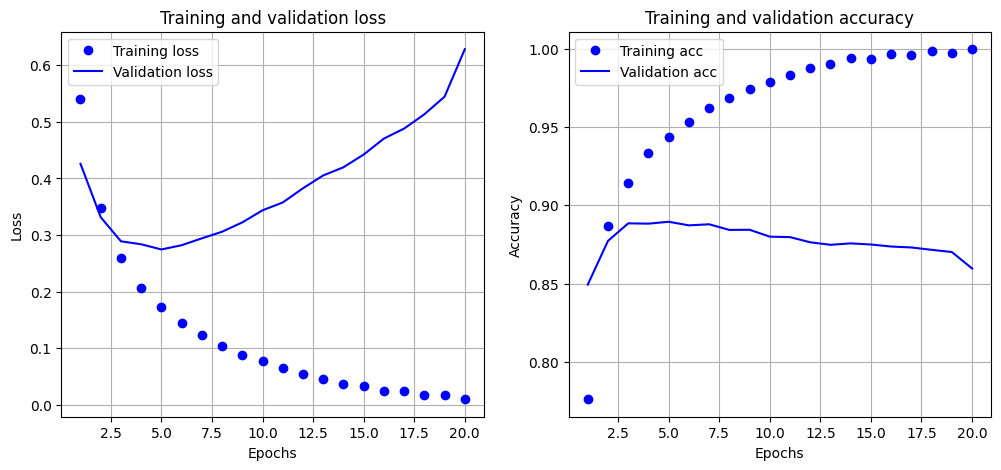

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8515 - loss: 0.6831
Тестовая потеря и точность: [0.6830506920814514, 0.8514800071716309]


In [18]:
import matplotlib.pyplot as plt

# Построение и компиляция модели
baseline_model = build_model()
baseline_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Обучение модели
baseline_history = baseline_model.fit(partial_x_train,
                                      partial_y_train,
                                      epochs=20,
                                      batch_size=batch_size,
                                      validation_data=(x_val, y_val),
                                      verbose=1)

# Сохранение метрик
history_dict = baseline_history.history
print("Итоговая точность на валидации:", history_dict['val_accuracy'][-1])
print("Итоговая потеря на валидации:", history_dict['val_loss'][-1])

# Графики потерь и точности
def plot_history(history_dict):
    epochs = range(1, len(history_dict['loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Точность
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_history(history_dict)

# Оценка на тестовых данных
results = baseline_model.evaluate(x_test, y_test)
print("Тестовая потеря и точность:", results)

#### 3. Реализация покоординатного спуска

In [19]:
# --- Вспомогательная функция для вычисления потерь ---
@tf.function
def compute_loss(model, x, y):
    """Вычисляет среднюю потерю для батча."""
    # Убеждаемся, что метки имеют правильную форму (batch, 1)
    y = tf.expand_dims(y, axis=-1)
    # Прямое распространение
    logits = model(x, training=True)
    # Вычисление потерь (бинарная Кросс-Энтропия)
    loss_value = tf.keras.losses.binary_crossentropy(y, logits)
    return tf.reduce_mean(loss_value)

def armijo_line_search_single_block(model, block_index, x_batch, y_batch, initial_alpha=1.0, c=1e-4, rho=0.5):
    w = model.trainable_variables[block_index]
    
    # 1. Вычисляем градиент g и начальную потерю f_w
    with tf.GradientTape() as tape:
        f_w = compute_loss(model, x_batch, y_batch)
    g = tape.gradient(f_w, w)
    
    # 2. Вычисляем градиент * направление (p = -g)
    # grad_f(w)^T * p = - ||grad_f(w)||^2
    grad_dot_p = -tf.reduce_sum(tf.square(g))
    
    alpha = initial_alpha
    original_w_value = tf.identity(w) # Сохраняем значение блока
    
    for _ in range(20): # Ограничение итераций
        # Шаг 3a: Вычисляем новое значение w_new = w - alpha * g
        w_new_value = original_w_value - alpha * g
        
        # Шаг 3b: Временно устанавливаем новое значение блока для вычисления f(w + alpha * p)
        w.assign(w_new_value)
        f_w_plus_alpha_p = compute_loss(model, x_batch, y_batch)
        
        # Шаг 3c: Восстанавливаем оригинальное значение блока
        w.assign(original_w_value)
        
        # Шаг 3d: Проверка условия Армихо
        armijo_condition = f_w + c * alpha * grad_dot_p
        
        if f_w_plus_alpha_p <= armijo_condition:
            return alpha, g # Возвращаем найденный alpha и градиент
        else:
            alpha *= rho
            
    return alpha, g # Возвращаем последний (самый маленький) alpha и градиент

#### 4. Кастомный цикла обучения

In [20]:
# Кастомный цикл обучения с БПС Line Search
def custom_train_block_cd_line_search(model, train_dataset, val_dataset, epochs):
    # ... инициализация метрик ...
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    print("\n" + "="*70)
    print("НАЧАЛО ОБУЧЕНИЯ С БПС (LINE SEARCH)")
    print("="*70)
    
    for epoch in range(epochs):
        train_loss = tf.keras.metrics.Mean()
        train_accuracy = tf.keras.metrics.BinaryAccuracy()
        
        for x_batch, y_batch in train_dataset:
            # Итерация по каждому блоку весов
            for block_index in range(len(model.trainable_variables)):
                
                # 1. Находим оптимальный шаг alpha и градиент g для текущего блока
                # Важно: compute_loss внутри armijo_line_search_single_block 
                # использует текущее состояние ВСЕЙ модели, включая уже обновленные блоки.
                alpha, g = armijo_line_search_single_block(
                    model, 
                    block_index, 
                    x_batch, 
                    y_batch
                )
                
                # 2. Обновляем только текущий блок (покоординатный спуск)
                w = model.trainable_variables[block_index]
                w.assign_sub(alpha * g)
                
            # ... обновление метрик для батча ...
            loss_value = compute_loss(model, x_batch, y_batch)
            train_loss(loss_value)
            y_batch_expanded = tf.expand_dims(y_batch, axis=-1)
            train_accuracy(y_batch_expanded, model(x_batch, training=False))
        
        # Валидация после эпохи
        val_loss = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.BinaryAccuracy()
        for x_batch_val, y_batch_val in val_dataset:
            loss_value = compute_loss(model, x_batch_val, y_batch_val)
            val_loss(loss_value)
            y_batch_val_expanded = tf.expand_dims(y_batch_val, axis=-1)
            val_accuracy(y_batch_val_expanded, model(x_batch_val, training=False))
        
        # Сохранение истории
        history['loss'].append(train_loss.result().numpy())
        history['accuracy'].append(train_accuracy.result().numpy())
        history['val_loss'].append(val_loss.result().numpy())
        history['val_accuracy'].append(val_accuracy.result().numpy())
        
        # Логирование эпохи
        print(f"Epoch {epoch+1}/{epochs}: Loss: {train_loss.result():.4f}, Acc: {train_accuracy.result():.4f}, Val Loss: {val_loss.result():.4f}, Val Acc: {val_accuracy.result():.4f}")
    
    return history

#### 5. Обучение и оценка

Обучаем модель с помощью кастомного цикла, и собираем данные о потерях и точности на каждой эпохе.


НАЧАЛО ОБУЧЕНИЯ С БПС (LINE SEARCH)
Epoch 1/20: Loss: 0.3977, Acc: 0.8277, Val Loss: 0.6391, Val Acc: 0.7457
Epoch 2/20: Loss: 0.2840, Acc: 0.8793, Val Loss: 0.3869, Val Acc: 0.8448
Epoch 3/20: Loss: 0.2193, Acc: 0.9121, Val Loss: 0.3742, Val Acc: 0.8574
Epoch 4/20: Loss: 0.1884, Acc: 0.9273, Val Loss: 0.3974, Val Acc: 0.8516
Epoch 5/20: Loss: 0.1827, Acc: 0.9309, Val Loss: 0.4073, Val Acc: 0.8523
Epoch 6/20: Loss: 0.1662, Acc: 0.9383, Val Loss: 0.4304, Val Acc: 0.8620
Epoch 7/20: Loss: 0.1443, Acc: 0.9465, Val Loss: 0.3990, Val Acc: 0.8670
Epoch 8/20: Loss: 0.1435, Acc: 0.9464, Val Loss: 0.4226, Val Acc: 0.8622
Epoch 9/20: Loss: 0.1317, Acc: 0.9533, Val Loss: 0.4482, Val Acc: 0.8593
Epoch 10/20: Loss: 0.1234, Acc: 0.9569, Val Loss: 0.4420, Val Acc: 0.8640
Epoch 11/20: Loss: 0.1120, Acc: 0.9615, Val Loss: 0.4860, Val Acc: 0.8569
Epoch 12/20: Loss: 0.1188, Acc: 0.9567, Val Loss: 0.4613, Val Acc: 0.8556
Epoch 13/20: Loss: 0.1066, Acc: 0.9607, Val Loss: 0.5053, Val Acc: 0.8525
Epoch 14/2

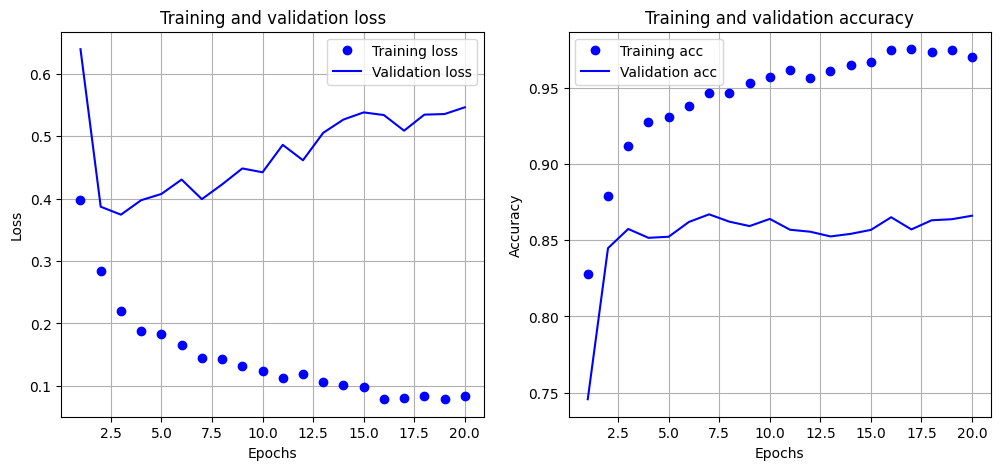

In [21]:
# Обучение модели
model = build_model()
final_history = custom_train_block_cd_line_search(model, train_dataset, val_dataset, epochs=20)

# Оценка на тесте
test_loss = tf.keras.metrics.Mean()
test_acc = tf.keras.metrics.BinaryAccuracy()

for x_batch_test, y_batch_test in test_dataset:
    y_batch_test = tf.expand_dims(y_batch_test, axis=-1)  # Исправление формы
    test_logits = model(x_batch_test, training=False)
    test_loss_value = tf.keras.losses.binary_crossentropy(y_batch_test, test_logits)
    test_loss(tf.reduce_mean(test_loss_value))
    test_acc(y_batch_test, test_logits)

print(f"Тестовая потеря: {test_loss.result().numpy():.4f}, Тестовая точность: {test_acc.result().numpy():.4f}")

plot_history(final_history)

#### 6. Сравнительный анализ и выводы

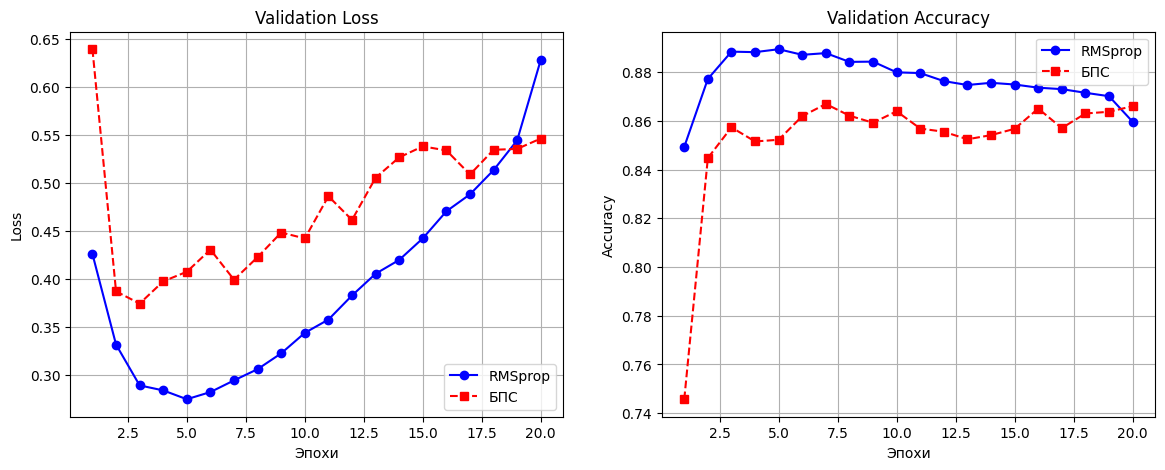

In [22]:
def compare_histories(baseline_hist, custom_hist):
    epochs = range(1, 21)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, baseline_hist.history['val_loss'], 'b-o', label='RMSprop')
    plt.plot(epochs, custom_hist['val_loss'], 'r--s', label='БПС')
    plt.title('Validation Loss')
    plt.xlabel('Эпохи')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, baseline_hist.history['val_accuracy'], 'b-o', label='RMSprop')
    plt.plot(epochs, custom_hist['val_accuracy'], 'r--s', label='БПС')
    plt.title('Validation Accuracy')
    plt.xlabel('Эпохи')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_histories(baseline_history, final_history)